In [1]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy.io.matlab import loadmat
import tensorflow as tf
import numpy as np
import random
import os

In [2]:
batch_size = 256
epochs = 100

In [3]:
image_path = 'training_and_validation_batches/1.mat'
temp = loadmat(image_path)

x = temp['affNISTdata']['image'][0][0].reshape(40, 40, 60000)
x = np.moveaxis(x, -1, 0)
x = np.expand_dims(x, axis=-1)
x = x/255.0

y = temp['affNISTdata']['label_int'][0][0]
y = np.moveaxis(y, -1, 0)
y = y.astype(np.int32)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [5]:
class Localization(tf.keras.layers.Layer):
    def __init__(self):
        super(Localization, self).__init__()
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv1 = tf.keras.layers.Conv2D(20, [5, 5], activation='relu')
        self.pool2 = tf.keras.layers.MaxPool2D()
        self.conv2 = tf.keras.layers.Conv2D(20, [5, 5], activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(20, activation='relu')
        self.fc2 = tf.keras.layers.Dense(6, activation=None, bias_initializer=tf.keras.initializers.constant([1.0, 0.0, 0.0, 0.0, 1.0, 0.0]), kernel_initializer='zeros')

    def build(self, input_shape):
        print("Building Localization Network with input shape:", input_shape)

    def compute_output_shape(self, input_shape):
        return [None, 6]

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        theta = self.fc2(x)
        theta = tf.keras.layers.Reshape((2, 3))(theta)
        return theta

In [6]:
class BilinearInterpolation(tf.keras.layers.Layer):
    def __init__(self, height=40, width=40):
        super(BilinearInterpolation, self).__init__()
        self.height = height
        self.width = width

    def compute_output_shape(self, input_shape):
        return [None, self.height, self.width, 1]

    def get_config(self):
        return {
            'height': self.height,
            'width': self.width,
        }
    
    def build(self, input_shape):
        print("Building Bilinear Interpolation Layer with input shape:", input_shape)

    def advance_indexing(self, inputs, x, y):
        '''
        Numpy like advance indexing is not supported in tensorflow, hence, this function is a hack around the same method
        '''        
        shape = tf.shape(inputs)
        batch_size, _, _ = shape[0], shape[1], shape[2]
        
        batch_idx = tf.range(0, batch_size)
        batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
        b = tf.tile(batch_idx, (1, self.height, self.width))
        indices = tf.stack([b, y, x], 3)
        return tf.gather_nd(inputs, indices)

    def call(self, inputs):
        images, theta = inputs
        homogenous_coordinates = self.grid_generator(batch=tf.shape(images)[0])
        return self.interpolate(images, homogenous_coordinates, theta)

    def grid_generator(self, batch):
        x = tf.linspace(-1, 1, self.width)
        y = tf.linspace(-1, 1, self.height)
            
        xx, yy = tf.meshgrid(x, y)
        xx = tf.reshape(xx, (-1,))
        yy = tf.reshape(yy, (-1,))
        homogenous_coordinates = tf.stack([xx, yy, tf.ones_like(xx)])
        homogenous_coordinates = tf.expand_dims(homogenous_coordinates, axis=0)
        homogenous_coordinates = tf.tile(homogenous_coordinates, [batch, 1, 1])
        homogenous_coordinates = tf.cast(homogenous_coordinates, dtype=tf.float32)
        return homogenous_coordinates
    
    def interpolate(self, images, homogenous_coordinates, theta):

        with tf.name_scope("Transformation"):
            transformed = tf.matmul(theta, homogenous_coordinates)
            transformed = tf.transpose(transformed, perm=[0, 2, 1])
            transformed = tf.reshape(transformed, [-1, self.height, self.width, 2])
                
            x_transformed = transformed[:, :, :, 0]
            y_transformed = transformed[:, :, :, 1]
                
            x = ((x_transformed + 1.) * tf.cast(self.width, dtype=tf.float32)) * 0.5
            y = ((y_transformed + 1.) * tf.cast(self.height, dtype=tf.float32)) * 0.5

        with tf.name_scope("VariableCasting"):
            x0 = tf.cast(tf.math.floor(x), dtype=tf.int32)
            x1 = x0 + 1
            y0 = tf.cast(tf.math.floor(y), dtype=tf.int32)
            y1 = y0 + 1

            x0 = tf.clip_by_value(x0, 0, self.width-1)
            x1 = tf.clip_by_value(x1, 0, self.width-1)
            y0 = tf.clip_by_value(y0, 0, self.height-1)
            y1 = tf.clip_by_value(y1, 0, self.height-1)
            x = tf.clip_by_value(x, 0, tf.cast(self.width, dtype=tf.float32)-1.0)
            y = tf.clip_by_value(y, 0, tf.cast(self.height, dtype=tf.float32)-1)

        with tf.name_scope("AdvanceIndexing"):
            Ia = self.advance_indexing(images, x0, y0)
            Ib = self.advance_indexing(images, x0, y1)
            Ic = self.advance_indexing(images, x1, y0)
            Id = self.advance_indexing(images, x1, y1)

        with tf.name_scope("Interpolation"):
            x0 = tf.cast(x0, dtype=tf.float32)
            x1 = tf.cast(x1, dtype=tf.float32)
            y0 = tf.cast(y0, dtype=tf.float32)
            y1 = tf.cast(y1, dtype=tf.float32)
                            
            wa = (x1-x) * (y1-y)
            wb = (x1-x) * (y-y0)
            wc = (x-x0) * (y1-y)
            wd = (x-x0) * (y-y0)

            wa = tf.expand_dims(wa, axis=3)
            wb = tf.expand_dims(wb, axis=3)
            wc = tf.expand_dims(wc, axis=3)
            wd = tf.expand_dims(wd, axis=3)
                        
        return tf.math.add_n([wa*Ia + wb*Ib + wc*Ic + wd*Id])

In [7]:
def get_model(input_shape):
    image = tf.keras.layers.Input(shape=input_shape)
    theta = Localization()(image)
    x = BilinearInterpolation(height=input_shape[0], width=input_shape[1])([image, theta])
    x = tf.keras.layers.Conv2D(64, [9, 9], activation='relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(64, [7, 7], activation='relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(10, activation='softmax')(x)

    return tf.keras.models.Model(inputs=image, outputs=x)

In [8]:
model = get_model((40, 40, 1))

Building Localization Network with input shape: (None, 40, 40, 1)
Building Bilinear Interpolation Layer with input shape: [TensorShape([None, 40, 40, 1]), TensorShape([None, 2, 3])]


In [9]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [10]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 40, 1)]  0                                            
__________________________________________________________________________________________________
localization (Localization)     (None, 2, 3)         30286       input_1[0][0]                    
__________________________________________________________________________________________________
bilinear_interpolation (Bilinea (None, 40, 40, 1)    0           input_1[0][0]                    
                                                                 localization[0][0]               
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 64)   5248        bilinear_interpolation

In [11]:
model.load_weights('./model/weights')

In [12]:
model.evaluate(X_test, y_test)

188/188 [==============================] - 3s 17ms/step - loss: 1.4723 - accuracy: 0.9887


[1.4722583293914795, 0.9886666536331177]

In [13]:
stn = tf.keras.models.Model(inputs=model.inputs, outputs=[model.layers[1].output, model.layers[2].output])

In [14]:
theta, prediction = stn.predict(X_test)

/home/parth/Desktop/Learning/spatial-transformer-network/venv/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:



 [[ 0.85481894  0.21389896  0.20679791]
 [-0.09544313  0.9402033   0.20598418]]


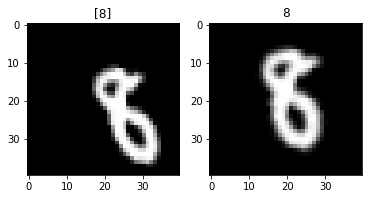

In [15]:
index = 3

plt.subplot(1,2,1)
plt.title(y_test[index])
plt.imshow(X_test[index, :, :, 0], cmap='gray')

plt.subplot(1, 2, 2)
plt.title(np.argmax(model.predict(np.expand_dims(X_test[index, :, :, 0], axis=0))))
plt.imshow(prediction[index, :, :, 0], cmap='gray')

print("\n", theta[index])

In [16]:
final_results = None
for i in range(5):
    inputs = None
    transformed = None
    for i in range(15):
        index = random.randint(0, X_test.shape[0]-1)
        
        if inputs is None:
            inputs = X_test[index, :, :, 0]
            transformed = prediction[index, :, :, 0]
        else:
            temp = np.ones((40, 5))
            inputs = np.hstack([inputs, temp])
            inputs = np.hstack([inputs, X_test[index, :, :, 0]])
            transformed = np.hstack([transformed, temp])
            transformed = np.hstack([transformed, prediction[index, :, :, 0]])
            
    inputs = np.asarray(inputs)
    transformed = np.asarray(transformed)
    
    if final_results is None:
        final_results = inputs
        temp = np.ones((1, 40 * 15 + 14 * 5))
        final_results = np.vstack([final_results, temp])
        final_results = np.vstack([final_results, transformed])
    else:
        temp = np.ones((10, 40 * 15 + 14 * 5))
        final_results = np.vstack([final_results, temp])
        final_results = np.vstack([final_results, inputs])
        temp = np.ones((1, 40 * 15 + 14 * 5))
        final_results = np.vstack([final_results, temp])
        final_results = np.vstack([final_results, transformed])

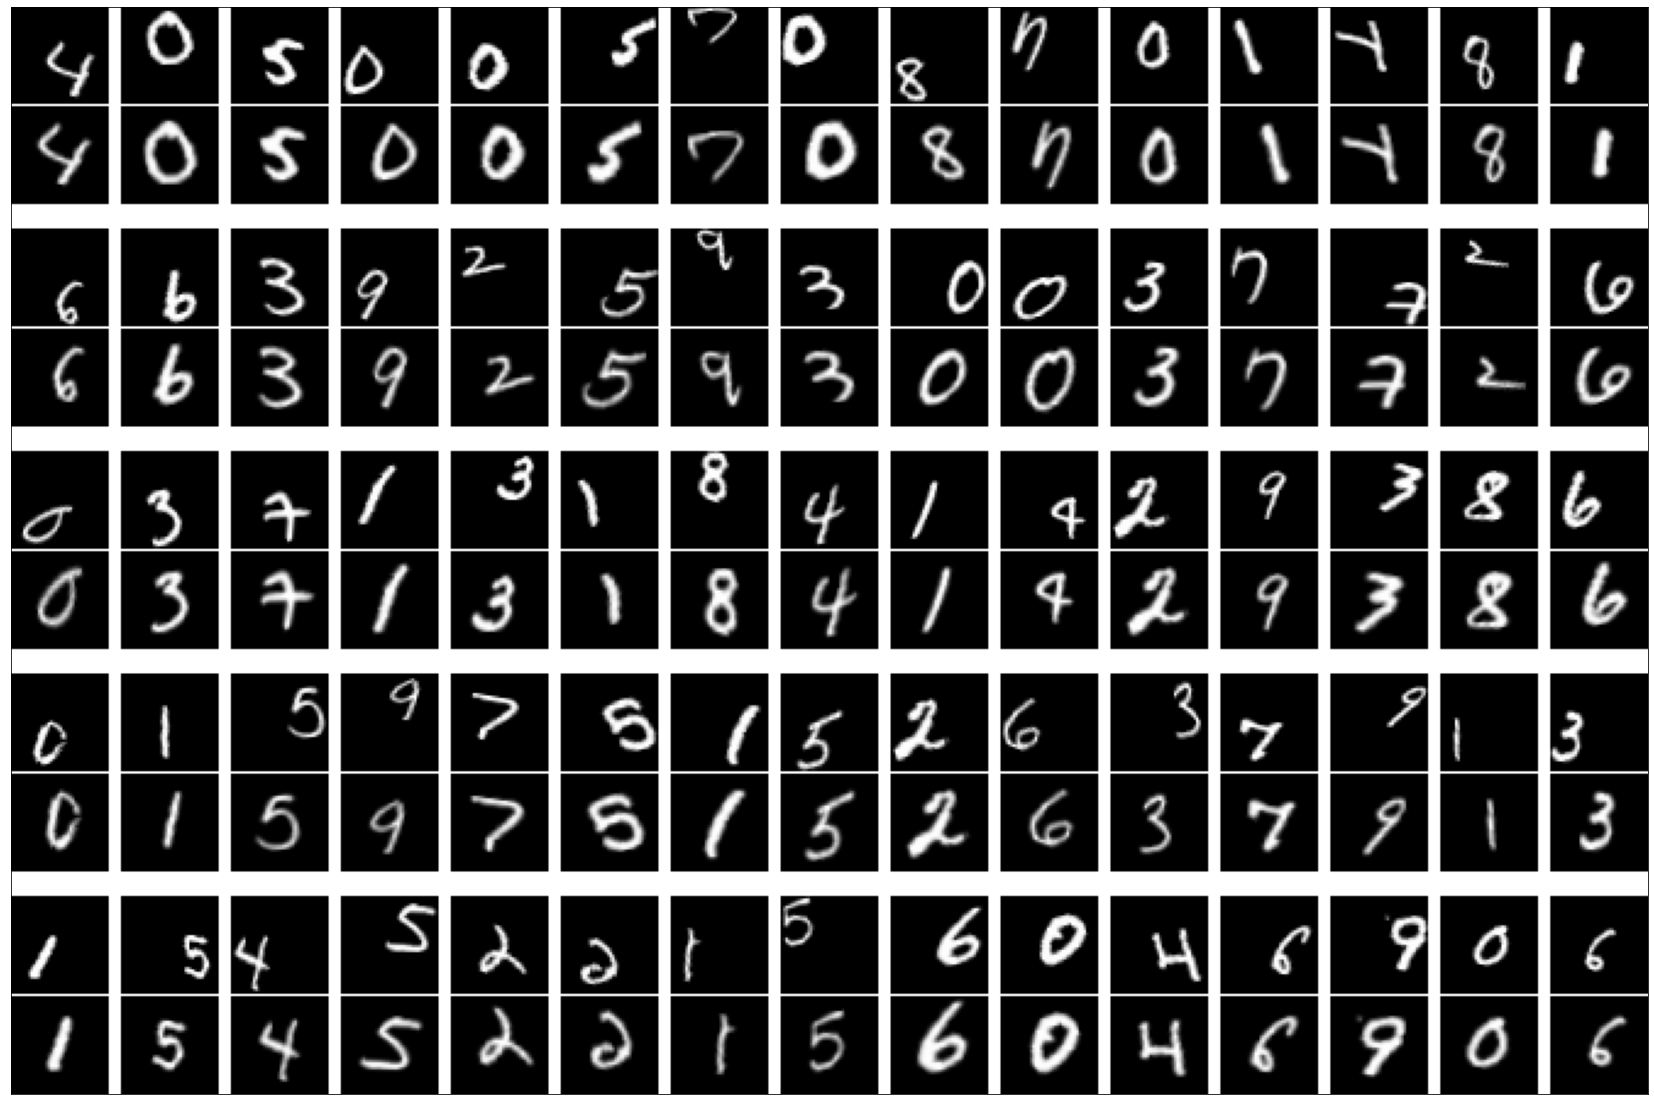

In [17]:
plt.figure(figsize=(30, 20))
plt.imshow(final_results, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig('images/visualization.jpg')
plt.show()